# Creating a Color Magnitude Diagram from Ananke 

In [26]:
import numpy as np
from matplotlib import pyplot as plt
import os
import vaex

In [27]:
%matplotlib inline

## Access Data

In [28]:
# Get the current working directory
current_dir = os.getcwd()

# Go back one directory (to 'src') and then to 'mock'
ananke_file_path = os.path.join(current_dir, "..", "mock", "survey.sim.h5")
print(f"\nOpening data from: {ananke_file_path}")

# Check if the file exists
if os.path.exists(ananke_file_path):
    # Proceed with opening the file
    survey = vaex.open(ananke_file_path)
else:
    print("File does not exist.")


Opening data from: /home/jovyan/home/rubin_mw_mocks/src/analysis/../mock/survey.sim.h5


In [29]:
column_names = survey.column_names
print(column_names)

['age', 'alpha', 'dec', 'dmod', 'feh', 'glat', 'glon', 'grav', 'lsst_gmag', 'lsst_imag', 'lsst_rmag', 'lsst_umag', 'lsst_ymag', 'lsst_zmag', 'lum', 'mact', 'mtip', 'parentid', 'partid', 'px', 'py', 'pz', 'ra', 'rad', 'smass', 'teff', 'vx', 'vy', 'vz']


## Create HR Diagram

The following code was adapted from: https://github.com/athob/anankethon/blob/main/usage_example.ipynb.

In [30]:
hex_cmap = 'cividis'
hex_cmap = plt.get_cmap(hex_cmap)

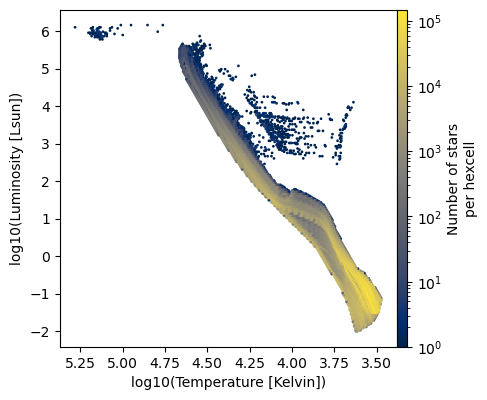

In [31]:
luminosity = survey.lum.to_numpy()
temperature = survey.teff.to_numpy()

fig3,axs=plt.subplots(nrows=1,ncols=3,figsize=(20,8), subplot_kw={'adjustable':'box'})
fig3.subplots_adjust(wspace=0.8)
for ax in axs[1:]: ax.set_visible(False)

hb = axs[0].hexbin(temperature, luminosity, gridsize=(241),
                   bins='log', cmap=hex_cmap)

axs[0].invert_xaxis()
axs[0].set_xlabel('log10(Temperature [Kelvin])')
axs[0].set_ylabel('log10(Luminosity [Lsun])')
axs[0].set_aspect(1.0/axs[0].get_data_ratio())

ax0color_axis = axs[0].inset_axes([1, 0., 0.03, 1.], transform=axs[0].transAxes)

ax0cbar = fig3.colorbar(hb, cax=ax0color_axis, location='right')
ax0cbar.set_label('Number of stars\nper hexcell')

## Distance Modulus

In [32]:
# Extract distance modulus
dmod = survey.dmod.to_numpy()

In [33]:
# Extract distance as parsecs (originally in kpc)
px = survey.px.to_numpy() * 1000
py = survey.py.to_numpy() * 1000
pz = survey.pz.to_numpy() * 1000

distance = np.sqrt(px**2 + py**2 + pz**2)

In [34]:
# Calculate dmod from distance
calculated_dmod = 5 * np.log10(distance) - 5

In [35]:
# Downsample for speed 
downsampled_indices = np.arange(0, len(dmod), 10)

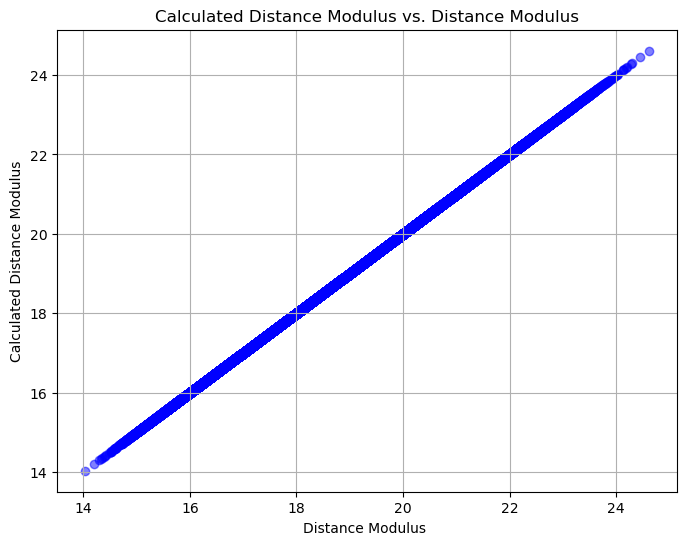

In [36]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
#plt.scatter(dmod, calculated_dmod, alpha=0.5, color='blue')
plt.scatter(dmod[downsampled_indices], calculated_dmod[downsampled_indices], alpha=0.5, color='blue')

# Set labels and title
plt.xlabel('Distance Modulus ')
plt.ylabel('Calculated Distance Modulus')
plt.title('Calculated Distance Modulus vs. Distance Modulus')

# Show grid
plt.grid(True)

# Show the plot
plt.show()

## Distance

In [37]:
# If our color mag plot doesn't work, add a distance limit, only store the sources left to the peak. 

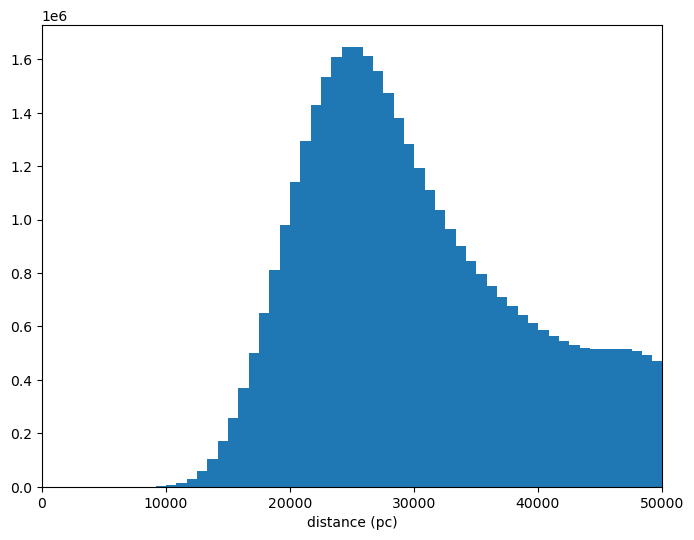

In [38]:
# Create a histogram of distances
plt.figure(figsize=(8, 6))
plt.hist(distance, bins=1000)

plt.xlabel("distance (pc)")
plt.xlim(0, 50000)

# Show the plot
plt.show()

### Distance Mask

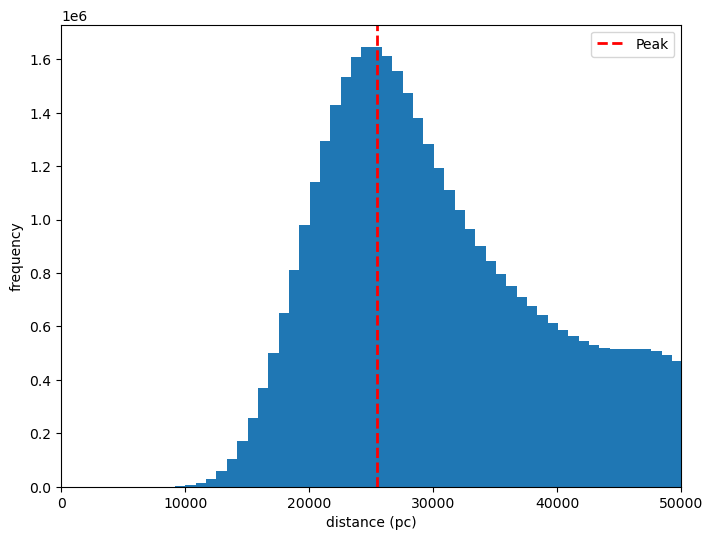

Peak center: 25442.02962582447 pc


In [39]:
from scipy.signal import find_peaks

# Create a histogram of distances and highlight the peak
plt.figure(figsize=(8, 6))
hist, edges, _ = plt.hist(distance, bins=1000)  # Use underscores to capture additional outputs

plt.xlabel("distance (pc)")
plt.ylabel("frequency")
plt.xlim(0, 50000)

# Find peaks in the histogram using scipy.signal.find_peaks
peaks, _ = find_peaks(hist)

# Find the index of the highest peak
peak_bin_index = peaks[np.argmax(hist[peaks])]
#peak_bin_index = np.argmax(hist) # Alternative without scipy.signal.find_peaks

# Calculate the bin center corresponding to the peak
peak_bin_center = (edges[peak_bin_index] + edges[peak_bin_index + 1]) / 2

# Highlight the peak on the histogram
plt.axvline(peak_bin_center, color='red', linestyle='dashed', linewidth=2, label='Peak')

# Show the plot
plt.legend()
plt.show()

# Print the center value
print(f"Peak center: {peak_bin_center} pc")

In [40]:
# Create a mask for distance
distance_mask = (distance >= peak_bin_center)

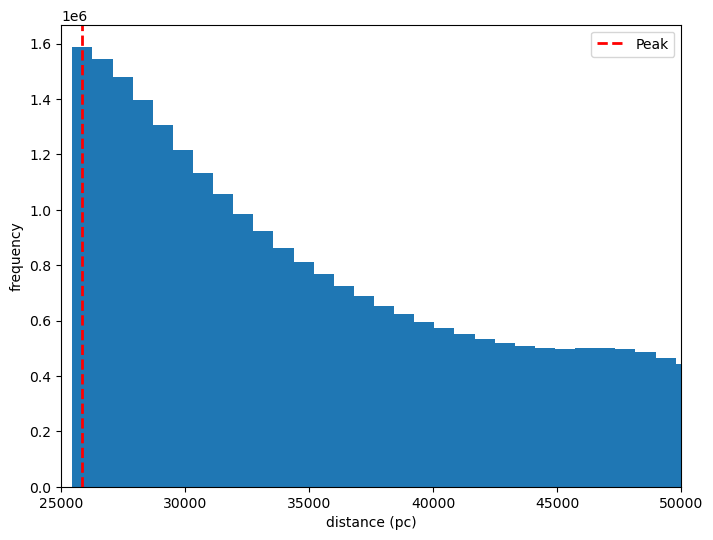

In [41]:
# Create a histogram of distances with distance mask
plt.figure(figsize=(8, 6))
hist, edges, _ = plt.hist(distance[distance_mask], bins=1000)  # Use underscores to capture additional outputs

plt.xlabel("distance (pc)")
plt.ylabel("frequency")
rounded_peak = round(peak_bin_center / 1000) * 1000 # Round the peak to the nearest 1000 for the lower limit
plt.xlim(rounded_peak, 50000)

# Find the bin with the highest frequency
peak_bin_index = np.argmax(hist)

# Calculate the bin center corresponding to the peak
peak_bin_center = (edges[peak_bin_index] + edges[peak_bin_index + 1]) / 2

# Highlight the peak on the histogram
plt.axvline(peak_bin_center, color='red', linestyle='dashed', linewidth=2, label='Peak')

# Show the plot
plt.legend()
plt.show()

## Galactic Latitude

In [42]:
# Filter out -15 to 15 glat. 
# After, try removing only the peaks. 
# Finally, create a Mag color diagram but only for the galaxies. Do not use any other filters that we added. 
# Make sure all the samples / filters are parameters

In [43]:
# Extract galactic latitude 
glat = survey.glat.to_numpy()

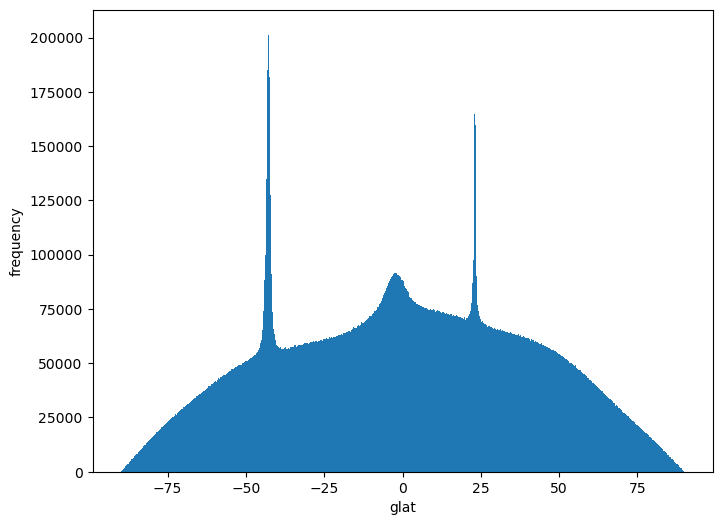

In [44]:
# Histogram of glat
plt.figure(figsize=(8, 6))
plt.hist(glat, bins=1000)

plt.xlabel("glat")
plt.ylabel("frequency")

# Show the plot
plt.show()

### Glat Plane Mask

In [74]:
# Create a mask to filter out anything between -15 to 15 glat
glat_plane_mask = (glat <= -15) | (glat >= 15)

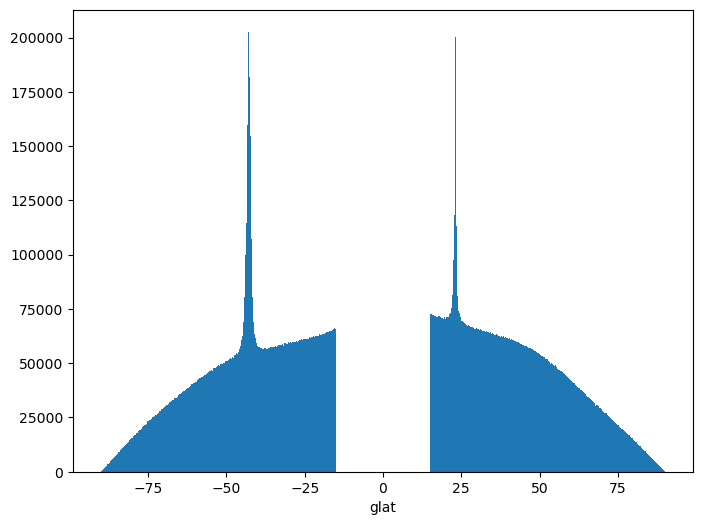

In [75]:
# Histogram of glat
glat = survey.glat.to_numpy()

plt.figure(figsize=(8, 6))
plt.hist(glat[glat_plane_mask], bins=1000)

plt.xlabel("glat")

# Show the plot
plt.show()

### Glat Peak Mask

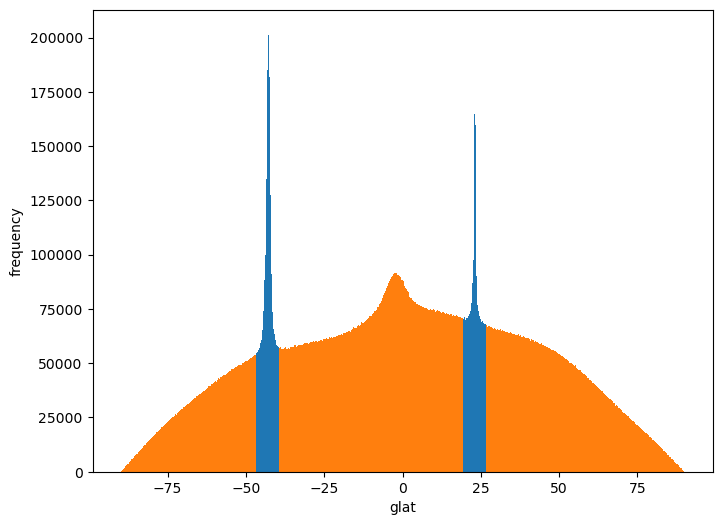

In [47]:
# Histogram of glat
plt.figure(figsize=(8, 6))
hist, edges, _ = plt.hist(glat, bins=1000)

plt.xlabel("glat")
plt.ylabel("frequency")

# Find peaks in the histogram
peaks, _ = find_peaks(hist)

# Sort peaks based on their heights
sorted_peaks = sorted(peaks, key=lambda x: hist[x], reverse=True)

# Extend the range of indices to include lower and higher values
exclude_range = 20
exclude_indices = []
for index in sorted_peaks[:2]:  # Use sorted_peaks here
    exclude_indices.extend(range(max(0, index - exclude_range), min(len(edges), index + exclude_range + 1)))

# Create a mask to remove the values corresponding to the peaks
glat_peak_mask = ~np.isin(np.digitize(glat, edges), exclude_indices)

# Plot the histogram without the values of the peaks
plt.hist(glat[glat_peak_mask], bins=1000)

# Show the plot
plt.show()

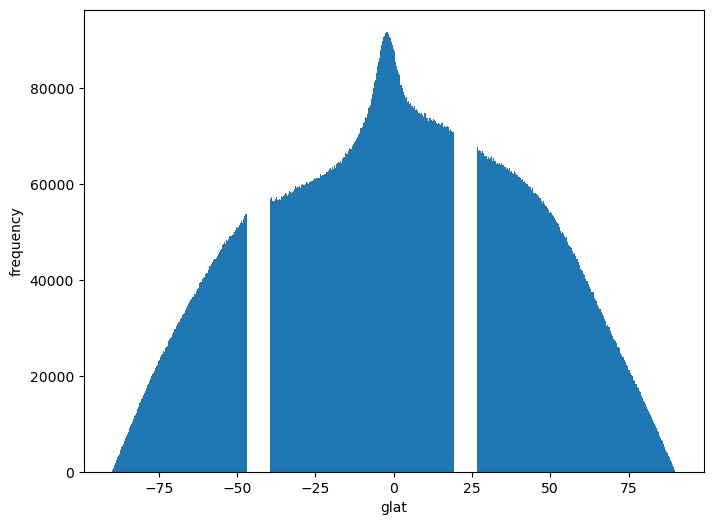

In [48]:
# Histogram of glat with mask applied
plt.figure(figsize=(8, 6))
plt.hist(glat[glat_peak_mask], bins=1000)

plt.xlabel("glat")
plt.ylabel("frequency")

# Show the plot
plt.show()

## Absolute Magnitude

In [54]:
# Extract color bands
g_mag = survey.lsst_gmag.to_numpy()
r_mag = survey.lsst_rmag.to_numpy()
i_mag = survey.lsst_imag.to_numpy()
u_mag = survey.lsst_umag.to_numpy()
y_mag = survey.lsst_ymag.to_numpy()
z_mag = survey.lsst_zmag.to_numpy()

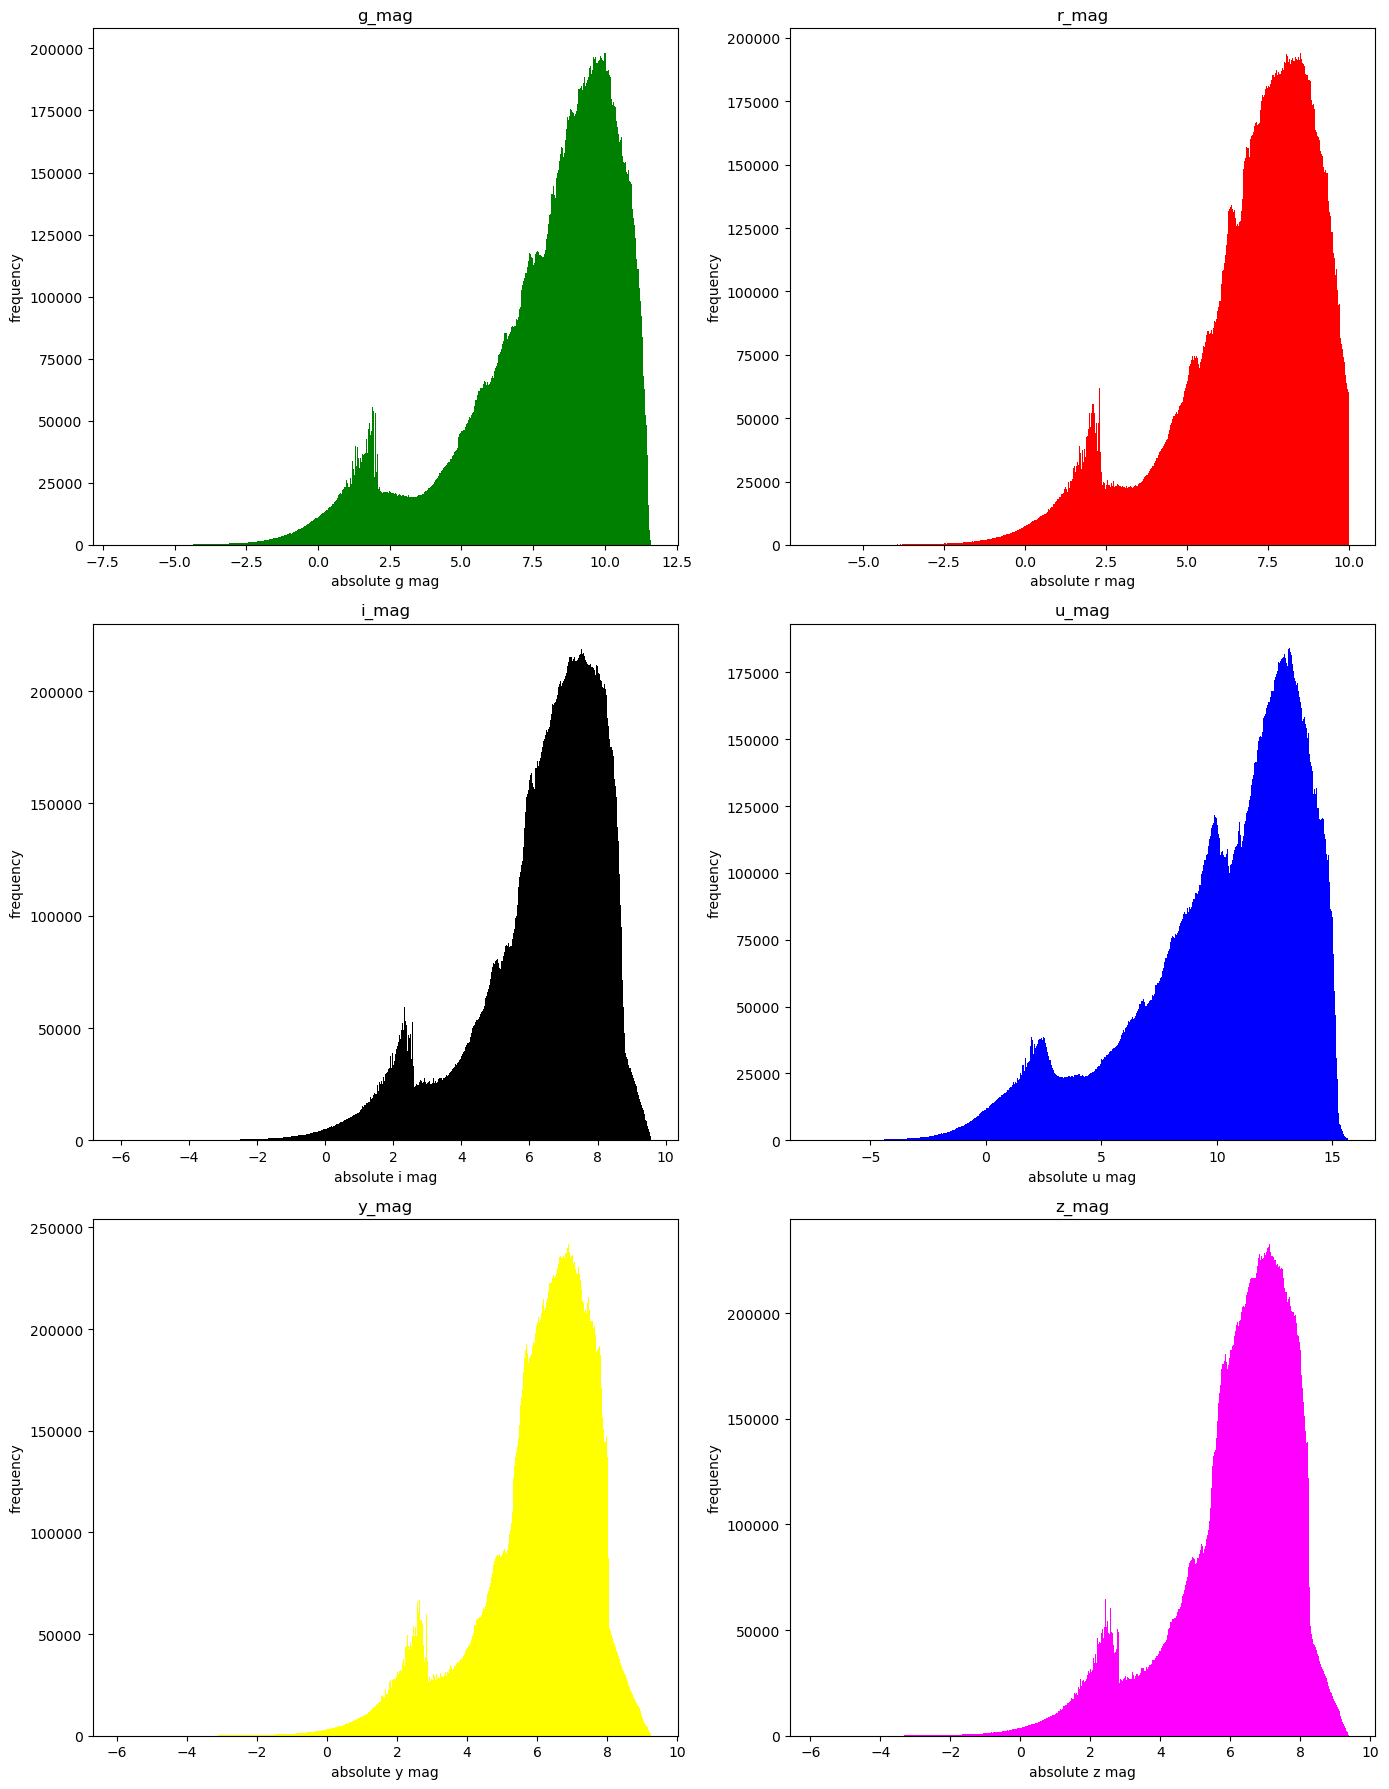

In [56]:
import matplotlib.pyplot as plt

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))
axs = axs.flatten()  # Convert to 1D list

# Subplot for g_mag
axs[0].hist(g_mag, bins=1000, color='green')
axs[0].set_xlabel("absolute g mag")
axs[0].set_ylabel("frequency")
axs[0].set_title('g_mag')

# Subplot for r_mag
axs[1].hist(r_mag, bins=1000, color='red')  
axs[1].set_xlabel("absolute r mag")
axs[1].set_ylabel("frequency")
axs[1].set_title('r_mag')

# Subplot for i_mag
axs[2].hist(i_mag, bins=1000, color='black')
axs[2].set_xlabel("absolute i mag")
axs[2].set_ylabel("frequency")
axs[2].set_title('i_mag')

# Subplot for u_mag
axs[3].hist(u_mag, bins=1000, color='blue')  
axs[3].set_xlabel("absolute u mag")
axs[3].set_ylabel("frequency")
axs[3].set_title('u_mag')

# Subplot for y_mag
axs[4].hist(y_mag, bins=1000, color='yellow')
axs[4].set_xlabel("absolute y mag")
axs[4].set_ylabel("frequency")
axs[4].set_title('y_mag')

# Subplot for z_mag
axs[5].hist(z_mag, bins=1000, color='magenta')  
axs[5].set_xlabel("absolute z mag")
axs[5].set_ylabel("frequency")
axs[5].set_title('z_mag')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [57]:
# Bokeh plots could reveal what problems we are encountering. 
# bokeh.org
# We can find where the satelite peaks in glat appear in other graphs

## Create $g-r$ vs $M_g$ Diagram

In [59]:
# Calculate g - r
g_minus_r = g_mag - r_mag

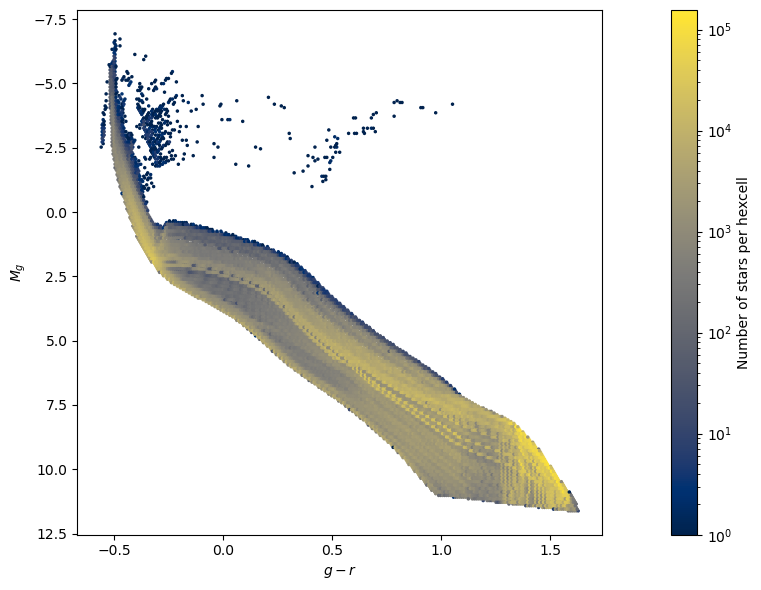

In [65]:
# Create the subplot
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# Create the hexbin, with 241 log bins and the hex_cmap colormap
hb = axs.hexbin(g_minus_r, g_mag, gridsize=(241), bins='log', cmap=hex_cmap)

# Setting labels
axs.set_xlabel('$g - r$')
axs.set_ylabel('$M_g$')
axs.set_aspect(1.0/axs.get_data_ratio())  # Set aspect ratio
axs.invert_yaxis()

# Colorbar
cbar = fig.colorbar(hb, ax=axs)
cbar.set_label('Number of stars per hexcell')

plt.tight_layout()
plt.show()

## Apparent Magnitude

In [66]:
def abs2app(M, d, A=0.0):
    """
    input:
    M = absolute magnitude
    d = distance (pc)
    A = extinction (mag/pc)
    
    returns:
    m = apparent magnitude
    """
    
    m = 5 * np.log10(d) - 5 + M + A*d
    
    return m

In [67]:
app_mag_g = abs2app(g_mag, distance)

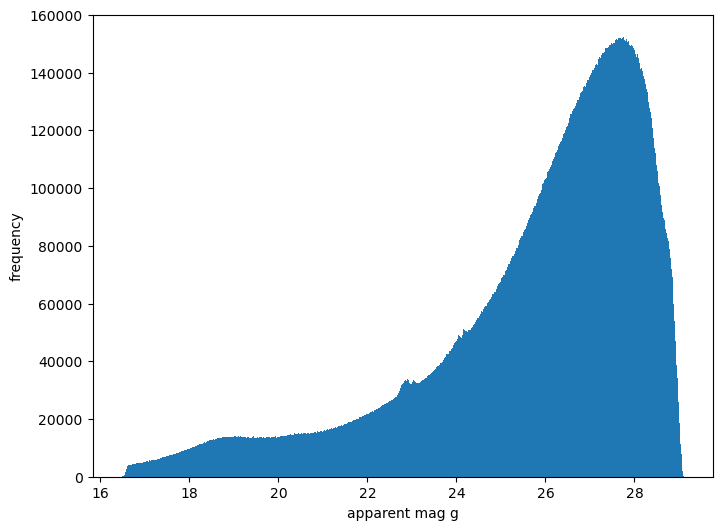

In [71]:
# Create a histogram of distances
plt.figure(figsize=(8, 6))
plt.hist(app_mag_g, bins=1000)
plt.xlabel("apparent mag g")
plt.ylabel("frequency")

# Show the plot
plt.show()

## Color Magnitude Diagram with Filters

In [78]:
# These should all be functions

We should simply be able to add masks to the `g_minus_r` and `g_mag` since order of ananke objects in the arrays should be maintained. In addition, adding masks in succession should also be possible.

### Distance mask 

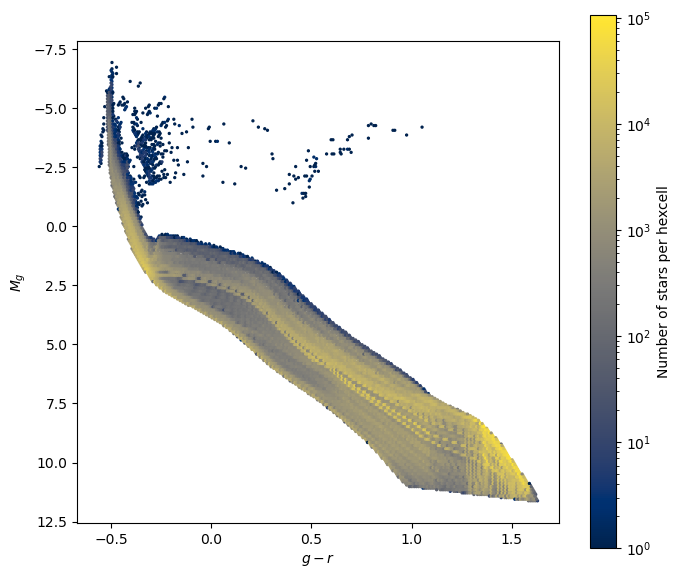

In [76]:
# Create the subplot
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))

# Create the hexbin, with 241 log bins and the hex_cmap colormap
hb = axs.hexbin(g_minus_r[distance_mask], g_mag[distance_mask], gridsize=(241), bins='log', cmap=hex_cmap)

# Setting lables
axs.set_xlabel('$g - r$')
axs.set_ylabel('$M_g$')
axs.set_aspect(1.0/axs.get_data_ratio())  # Set aspect ratio
axs.invert_yaxis()

# Colorbar
cbar = fig.colorbar(hb, ax=axs)
cbar.set_label('Number of stars per hexcell')

plt.tight_layout()
plt.show()

### Glat plane mask

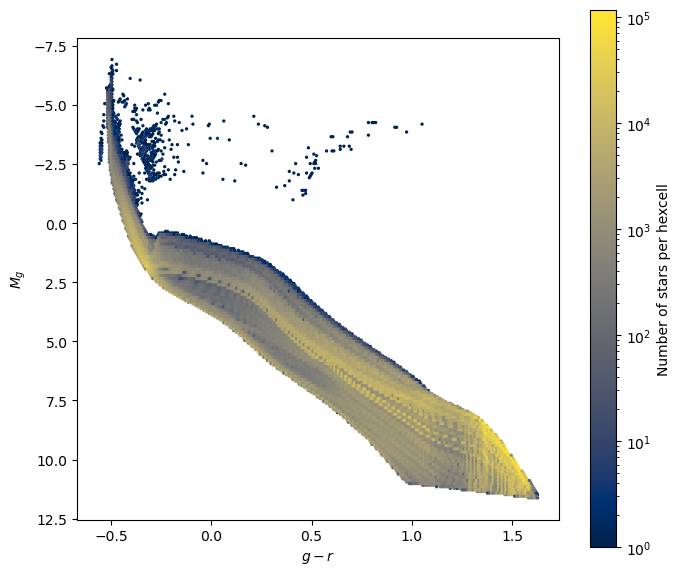

In [77]:
# Create the subplot
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))

# Create the hexbin, with 241 log bins and the hex_cmap colormap
hb = axs.hexbin(g_minus_r[glat_plane_mask], g_mag[glat_plane_mask], gridsize=(241), bins='log', cmap=hex_cmap)

# Setting lables
axs.set_xlabel('$g - r$')
axs.set_ylabel('$M_g$')
axs.set_aspect(1.0/axs.get_data_ratio())  # Set aspect ratio
axs.invert_yaxis()

# Colorbar
cbar = fig.colorbar(hb, ax=axs)
cbar.set_label('Number of stars per hexcell')

plt.tight_layout()
plt.show()

### Glat peak mask

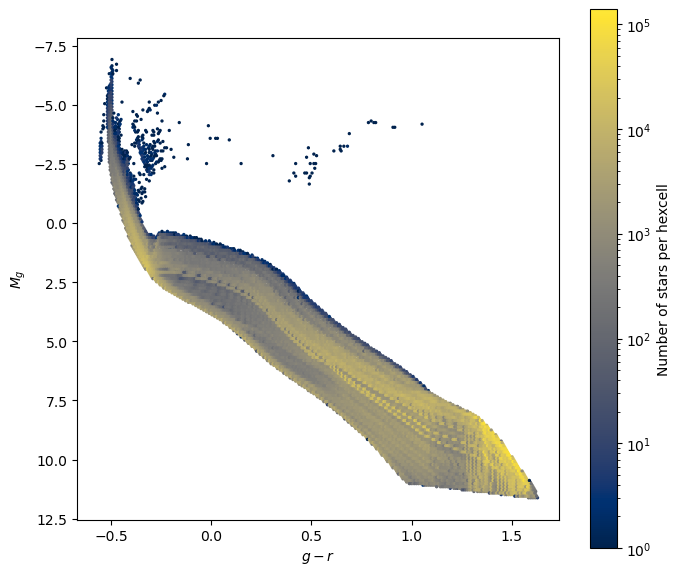

In [79]:
# Create the subplot
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))

# Create the hexbin, with 241 log bins and the hex_cmap colormap
hb = axs.hexbin(g_minus_r[glat_peak_mask], g_mag[glat_peak_mask], gridsize=(241), bins='log', cmap=hex_cmap)

# Setting lables
axs.set_xlabel('$g - r$')
axs.set_ylabel('$M_g$')
axs.set_aspect(1.0/axs.get_data_ratio())  # Set aspect ratio
axs.invert_yaxis()

# Colorbar
cbar = fig.colorbar(hb, ax=axs)
cbar.set_label('Number of stars per hexcell')

plt.tight_layout()
plt.show()